In [1]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import pairwise_distances
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv("./listings.csv")

In [5]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37541 entries, 0 to 37540
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            37541 non-null  int64  
 1   listing_url                                   37541 non-null  object 
 2   scrape_id                                     37541 non-null  int64  
 3   last_scraped                                  37541 non-null  object 
 4   source                                        37541 non-null  object 
 5   name                                          37539 non-null  object 
 6   description                                   36221 non-null  object 
 7   neighborhood_overview                         20891 non-null  object 
 8   picture_url                                   37540 non-null  object 
 9   host_id                                       37541 non-null 

#### Insights
1. host_since should be converted to host_duration_in_months
2. host_verifications should be converted host_number_of_verification_channels
3. host_response_rate and host_acceptance_rate should be converted to categorical such as
   if rate is [0,25] -> 1, [25,50] -> 2 etc.
4. amenities would be converted to number_of_amenities
5. price converted to numerical
6. first_review and last_review should converted to number_of_days_first_review, number_of_days_last_review
7. all review scores should be categorized [0,1] -> 1, [1,2] -> 2, [2,3] -> 3 etc.

In [6]:
features_after_sentiment = ["name", "description", "neighborhood_overview", "host_about"]

In [7]:
features_to_one_hot = ["host_response_time", "host_is_superhost", 
                       "neighbourhood_cleansed", "property_type",  "host_has_profile_pic", 
                       "host_identity_verified", "room_type", "instant_bookable"]

In [8]:
features_to_modify = ["host_since", "host_verifications", "host_response_rate", "host_acceptance_rate", "amenities", "first_review"
                      , "last_review"]

In [9]:
features_numerical = ["accommodates", "bathrooms", "bedrooms", "beds", "price",
                      "minimum_nights", "maximum_nights", "availability_30", "availability_60", "availability_90",
                     "number_of_reviews", "number_of_reviews_ltm", "number_of_reviews_l30d", "calculated_host_listings_count"
                      ,"calculated_host_listings_count_entire_homes", "calculated_host_listings_count_private_rooms"
                      ,"calculated_host_listings_count_shared_rooms"]

In [10]:
all_necessary_features = features_to_one_hot + features_numerical + features_to_modify

In [11]:
df_necessary_features = df[all_necessary_features]
df_cleaned = df_necessary_features.dropna()

### Conversion of some columns

#### Utility functions

In [12]:
def get_host_duration(col):
    months_duration = (datetime.now().year - datetime.strptime(col, "%Y-%m-%d").year) * 12 + (datetime.now().month - datetime.strptime(col, "%Y-%m-%d").month)
    return months_duration
def get_number_variations(col):
    import ast
    list_type = ast.literal_eval(col)
    return len(list_type)
def get_rates_categories(col):
    int_representation = int(col[:-1])
    if int_representation < 25:
        return 1
    elif int_representation >= 25 and int_representation < 50:
        return 2
    elif int_representation >= 50 and int_representation < 75:
        return 3
    else:
        return 4
def get_price_numeric(col):
    return float(col[1:].replace(',', ''))
def get_review_days(col):
    days_duration = (datetime.now() - datetime.strptime(col, "%Y-%m-%d")).days
    return days_duration

In [13]:
df_cleaned["host_duration_months"] = df_cleaned["host_since"].apply(lambda x: get_host_duration(x))
df_cleaned["host_number_of_verification_channels"] = df_cleaned["host_verifications"].apply(lambda x: get_number_variations(x))
df_cleaned["host_response_rate_category"] = df_cleaned["host_response_rate"].apply(lambda x: get_rates_categories(x))
df_cleaned["host_acceptance_rate_category"] = df_cleaned["host_acceptance_rate"].apply(lambda x: get_rates_categories(x))
df_cleaned["number_of_amenities"] = df_cleaned["amenities"].apply(lambda x: get_number_variations(x))
df_cleaned["price"] = df_cleaned["price"].apply(lambda x: get_price_numeric(x))
df_cleaned["first_review_duration"] = df_cleaned["first_review"].apply(lambda x: get_review_days(x))
df_cleaned["last_review_duration"] = df_cleaned["last_review"].apply(lambda x: get_review_days(x))

/var/folders/4m/s8hcw8_d02zgx8npr9k9fh4m0000gn/T/ipykernel_31632/1827157289.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["host_duration_months"] = df_cleaned["host_since"].apply(lambda x: get_host_duration(x))
/var/folders/4m/s8hcw8_d02zgx8npr9k9fh4m0000gn/T/ipykernel_31632/1827157289.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["host_number_of_verification_channels"] = df_cleaned["host_verifications"].apply(lambda x: get_number_variations(x))
/var/folders/4m/s8hcw8_d02zg

In [14]:
df_final = df_cleaned.drop(columns=features_to_modify)

In [15]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12978 entries, 1 to 37538
Data columns (total 32 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   host_response_time                            12978 non-null  object 
 1   host_is_superhost                             12978 non-null  object 
 2   neighbourhood_cleansed                        12978 non-null  object 
 3   property_type                                 12978 non-null  object 
 4   host_has_profile_pic                          12978 non-null  object 
 5   host_identity_verified                        12978 non-null  object 
 6   room_type                                     12978 non-null  object 
 7   instant_bookable                              12978 non-null  object 
 8   accommodates                                  12978 non-null  int64  
 9   bathrooms                                     12978 non-null  floa

In [16]:
final_string_features = df_final.select_dtypes(include='object').columns.tolist()
final_numeric_features = df_final.select_dtypes(include='number').columns.tolist()

In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), final_numeric_features),
        ('cat', OneHotEncoder(drop='first'), final_string_features)
    ])

processed_df = preprocessor.fit_transform(df_final)

In [18]:
distance_matrix = pairwise_distances(processed_df, metric='euclidean')

In [19]:
linkage_matrix = linkage(distance_matrix, method='ward')

/var/folders/4m/s8hcw8_d02zgx8npr9k9fh4m0000gn/T/ipykernel_31632/329720980.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='ward')


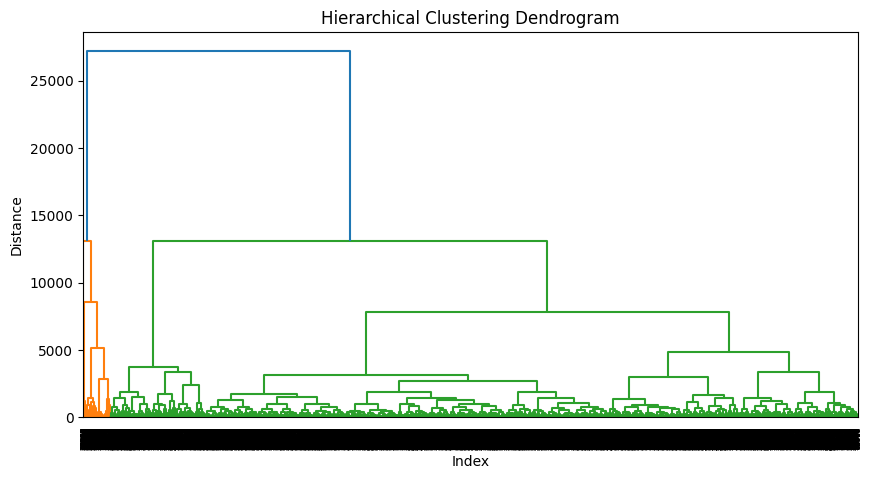

In [20]:
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix, labels=df_final.index.to_numpy())
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Index")
plt.ylabel("Distance")
plt.show()

In [21]:
clusters = fcluster(linkage_matrix, t=6, criterion='maxclust')
df_final['cluster'] = clusters

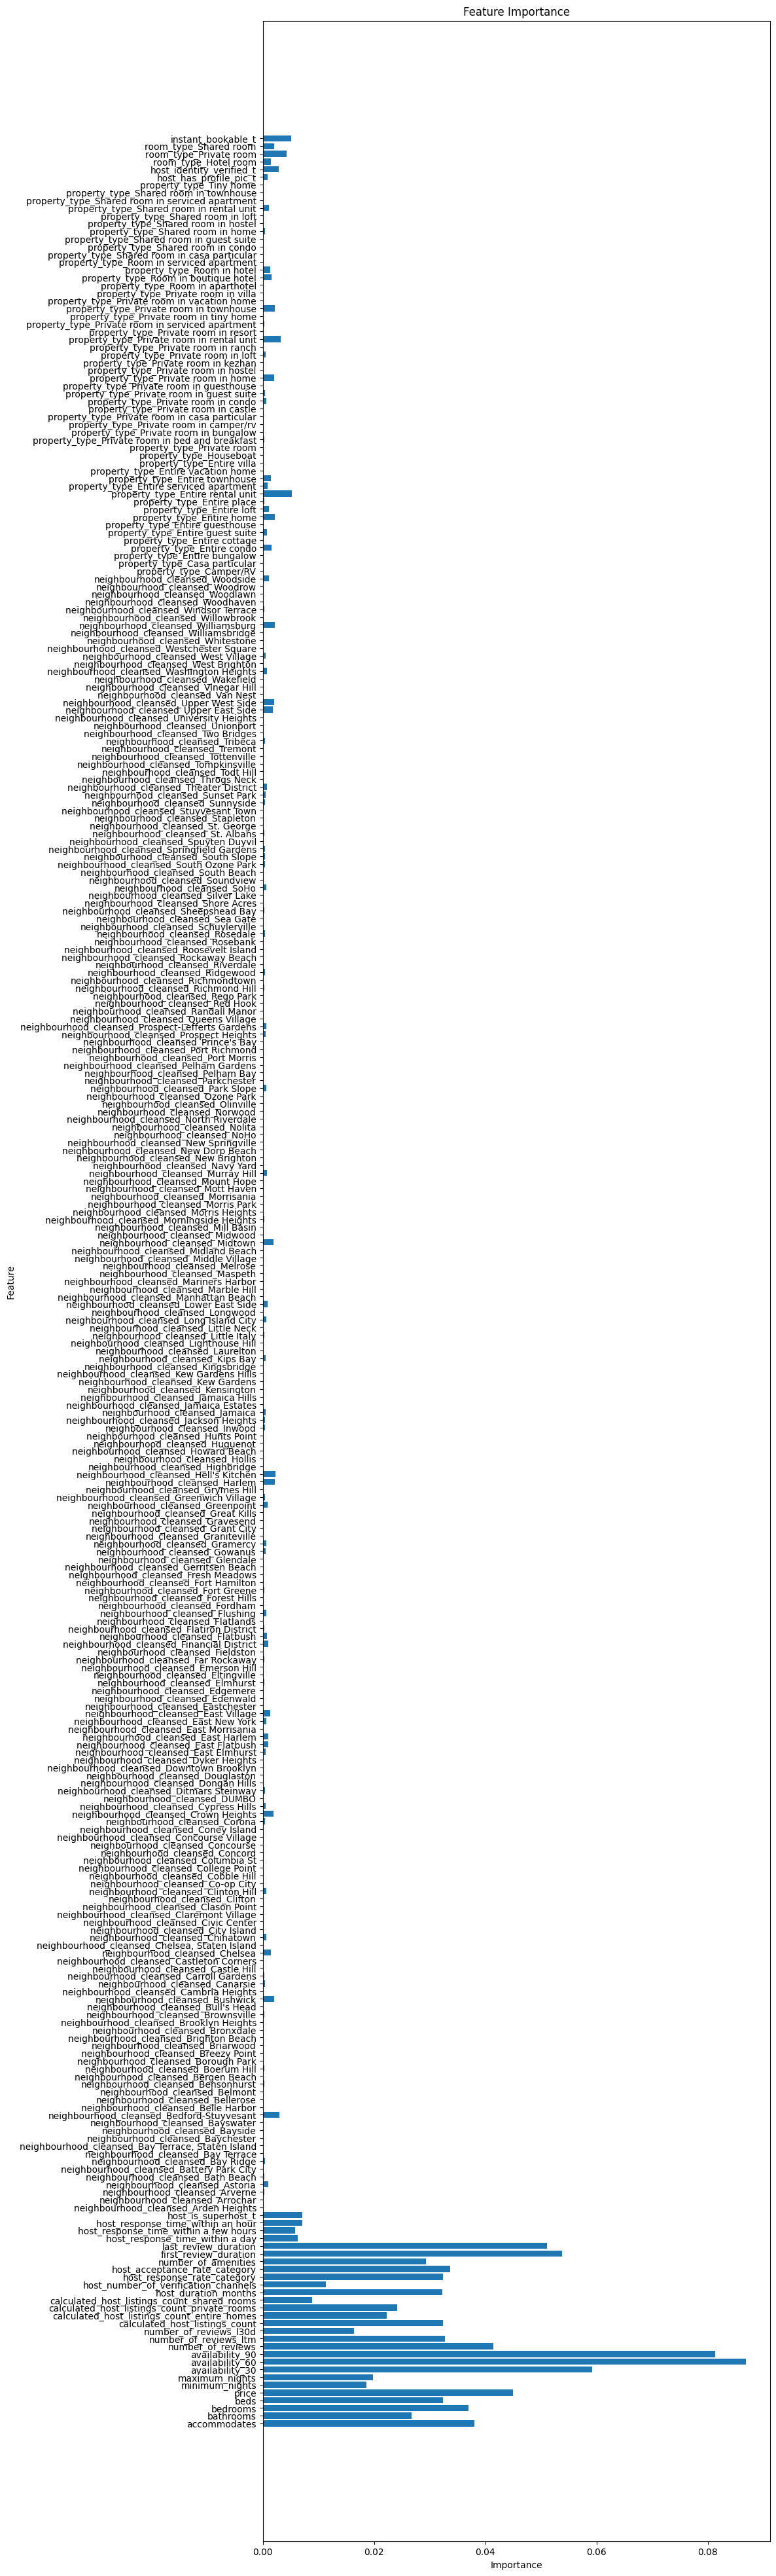

In [22]:
X = processed_df
y = df_final['cluster']

# Train Random Forest
rf = RandomForestClassifier(random_state=190)
rf.fit(X, y)

# Feature importance
feature_importance = rf.feature_importances_

# Map feature names
feature_names = (
    preprocessor.named_transformers_['num'].get_feature_names_out(final_numeric_features).tolist() +
    preprocessor.named_transformers_['cat'].get_feature_names_out(final_string_features).tolist()
)

# Plot feature importance
plt.figure(figsize=(10, 50))
plt.barh(feature_names, feature_importance)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

#### Most significant features that used in the clustering

In [23]:
res = []
for i,j in zip(feature_names, feature_importance):
    if j > 0.05:
        res.append((i,j))
res

[('availability_30', np.float64(0.05926168993508524)),
 ('availability_60', np.float64(0.08681980966758411)),
 ('availability_90', np.float64(0.08131163227249207)),
 ('first_review_duration', np.float64(0.05381577879035527)),
 ('last_review_duration', np.float64(0.0510583738715878))]

In [34]:
df_final[df_final["cluster"] == 4]["availability_90"].describe()

count    1585.000000
mean       46.721767
std        31.283611
min         0.000000
25%        21.000000
50%        46.000000
75%        77.000000
max        90.000000
Name: availability_90, dtype: float64